In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/household_power_consumption.csv'

In [8]:
df = pd.read_csv(file_path)

df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  260640 non-null  int64  
 1   Date                   260640 non-null  object 
 2   Time                   260640 non-null  object 
 3   Global_active_power    260640 non-null  object 
 4   Global_reactive_power  260640 non-null  object 
 5   Voltage                260640 non-null  object 
 6   Global_intensity       260640 non-null  object 
 7   Sub_metering_1         260640 non-null  object 
 8   Sub_metering_2         260640 non-null  object 
 9   Sub_metering_3         256869 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 19.9+ MB


In [10]:
df.isnull().sum()

,0
index,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,3771


## Preprossing

In [11]:
# Combining Date and Time into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Convert Global_active_power to float
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop rows with NaNs in relevant columns
df.dropna(subset=['Global_active_power'], inplace=True)

/tmp/ipython-input-3888819900.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)


In [12]:
df = df[['datetime', 'Global_active_power']]

daily_df = df.set_index('datetime').resample('D').sum().reset_index()

# Rename columns for Prophet
daily_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

daily_df.head()


,ds,y
0,2007-01-01,2749.004
1,2007-01-02,1269.236
2,2007-01-03,1014.054
3,2007-01-04,3259.412
4,2007-01-05,2713.364


## Model

In [14]:
model = Prophet()

model.fit(daily_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg96eimwa/lokdsyy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg96eimwa/nogquxsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77032', 'data', 'file=/tmp/tmpg96eimwa/lokdsyy9.json', 'init=/tmp/tmpg96eimwa/nogquxsc.json', 'output', 'file=/tmp/tmpg96eimwa/prophet_modell0_22k60/prophet_model-20250802132750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forcasting

In [16]:
future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)

In [19]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
201,2007-07-21,1008.730501,207.630037,1830.004732
202,2007-07-22,1399.250147,595.873508,2197.196362
203,2007-07-23,688.498179,-139.795164,1515.516870
204,2007-07-24,508.460530,-317.931992,1261.229784
205,2007-07-25,871.423515,25.967811,1638.496264
206,2007-07-26,634.929524,-196.352706,1384.308752
207,2007-07-27,482.657247,-358.705704,1280.302382
208,2007-07-28,955.935444,200.016902,1781.615357
209,2007-07-29,1346.455090,588.551475,2133.330202
210,2007-07-30,635.703122,-146.245115,1439.978578


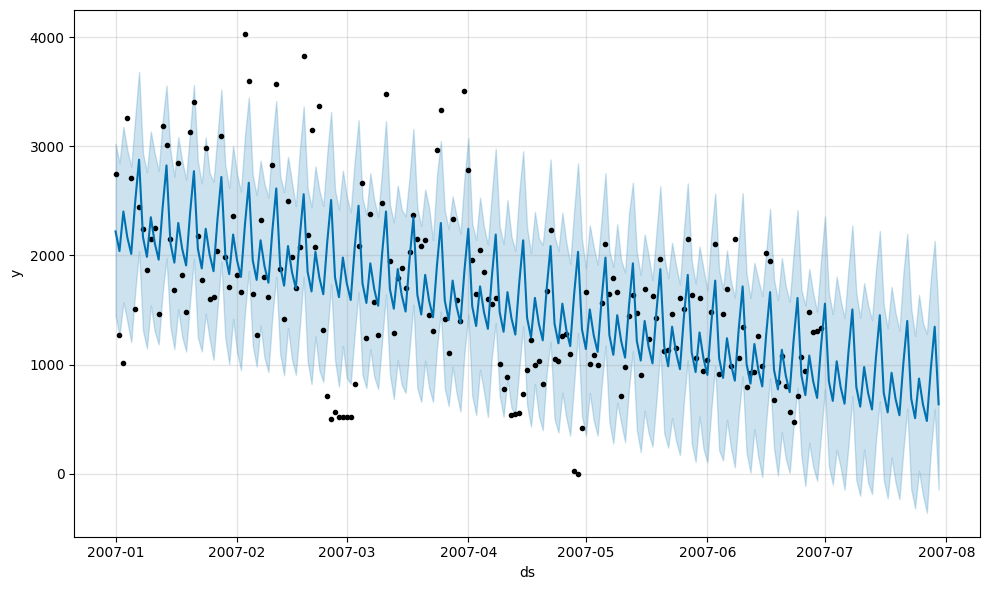

In [17]:
fig1 = model.plot(forecast)

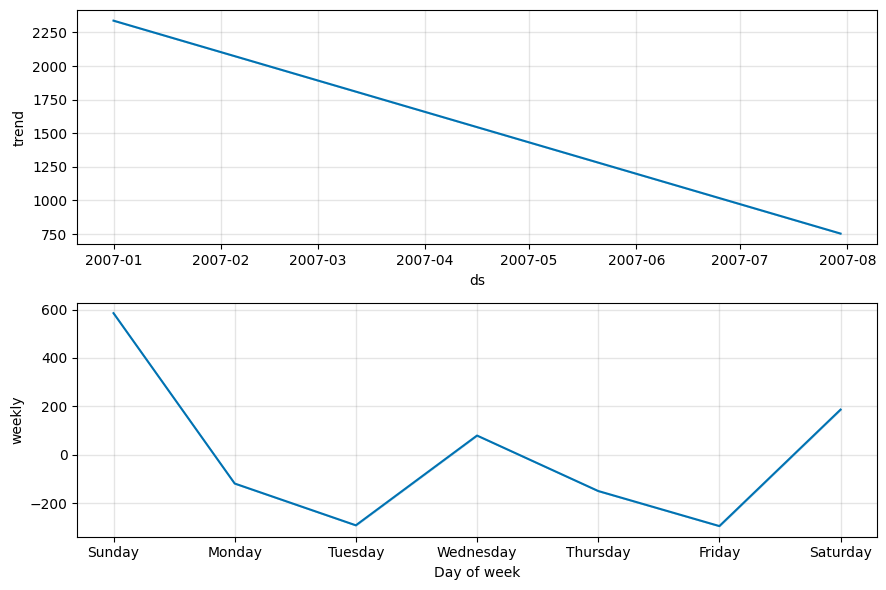

In [18]:
fig2 = model.plot_components(forecast)